# Importing the necessary modules

In [126]:
# Utilitaries
from csv import reader
import re
import pandas as pd
import zeep
# Data preparation and text manipulation
import nltk
from nltk.corpus import stopwords as stp
import nltk.stem.snowball as snowball
# Machine learning tools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Machine learning classificators
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# Machine learning model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

# Reading the corpus

In [2]:
df = pd.read_csv('corpus.csv')

In [3]:
df.sample(5)

,author,title,translation,label
76,Eftimie,BOR a cerut 1 miliard de dolari de la NASA ca ...,Echipajul va avea la el o candelă și un busuio...,0
930,TVR,"Ludovic Orban, despre demisie: Am considerat c...",Întrebat dacă preşedintele Klaus Iohannis i-a ...,1
970,TVR,Alegătorii din satele izolate vor să nu fie i...,"Cândva, pe ulițe se auzeau voci de copii. Acum...",1
866,TVR,"Negocierile pentru noile funcții, pe final. Pr...","Potrivit unor surse, liberalii ar urma să prei...",1
312,TNR,Costumul de tufiş cu care pândea Arafat români...,"„Mi-am dat seama prea târziu că ăla e un om, n...",0


# Data preparation

### Lemmatization
_Source: http://nlptools.info.uaic.ro/WebPosRo/_

In [4]:
wsdl = 'http://nlptools.info.uaic.ro/WebPosRo/PosTaggerRoWS?wsdl'

In [5]:
client = zeep.Client(wsdl=wsdl)

#### Transforming each article using the POS tagger,tokenizing and filtering the stopwords at the same time

In [6]:
lemmatized_articles_xml=[]

In [7]:
for article in df['translation']:
     lemmatized_articles_xml.append(client.service.parseSentence_XML(article))
    

In [8]:
# # Saving the articles to save execution time
# for article in lemmatized_articles_xml:
#     with open('lemmatized_articles','a+') as f:
#         f.write(article)
#         f.write('\n')

In [9]:
stopwords = stp.words('romanian')
lemmatized_articles_clean=[]
for article in lemmatized_articles_xml:
    article = article.split('\n')
    lemmas = []
    for line in article:
        found = re.search('.*LEMMA="([A-Za-zăâîșț1-9]*)".*', line)
        if found:
            word = found.group(1)
            if word not in stopwords:
                lemmas.append(word)
    lemmatized_articles_clean.append(lemmas)

#### Adding the lemmatized articles to the corpus

In [10]:
df['lemmatized_articles'] = lemmatized_articles_clean

In [11]:
df.sample(5)

,author,title,translation,label,lemmatized_articles
129,Vasile,Un român ambiţios şi-a făcut un pepene acasă d...,„Mai aştept luna plină ca să-i dau viaţă creaţ...,0,"[aștepta, lună, plin, viață, creație, sine, lă..."
529,Calin,Colțescu și-a învățat lecția: „Îi urez succes ...,"„Am evoluat mult de când iau meditații“, se la...",0,"[evolua, lua, meditație, sine, lăuda, Sebastia..."
200,Eftimie,Branșat la contracte cu statul! Dan Bittman va...,"„Decizia a fost luată la nivelul ministerului,...",0,"[decizie, luat, nivel, minister, ști, băga, no..."
96,Eftimie,"Elon Musk, devastat! O pisică spaţială i-a dăr...","China a anunțat că e dispusă să ajute, respect...",0,"[China, anunța, dispus, ajuta, respectiv, crea..."
229,Ionut,"Andi Moisescu, prins de Olivia Steer cu o șaor...","În consecință, Andi nu mai are voie să meargă ...",0,"[andi, voie, merge, român, talent, vrea, parti..."


#### Stemming

In [12]:
stemmed_articles = []
stemmer = snowball.SnowballStemmer('romanian')

for article in df['lemmatized_articles']:
    stemmed_words =[]
    for word in article:
        stemmed_words.append(stemmer.stem(word))
        # Appending the string form of the stemmed array because it will
        # be needed in the next step
    stemmed_articles.append(' '.join(stemmed_words))

#### Adding the stemmed articles to the corpus

In [13]:
df['stemmed_articles']=stemmed_articles

In [192]:
df.sample(5)

,author,title,translation,label,lemmatized_articles,stemmed_articles
636,TVR,Aproape 60 de mii de persoane au fost imunizat...,44.299 de persoane au fost vaccinate cu prima ...,1,"[persoană, vaccinat, doză, doză, primi, persoană]",persoan vaccin doz doz prim persoan
867,TVR,"Florin Cîțu, premier susținut de coaliție: Cre...",„Sunt măsuri care pot fi implementate foarte c...,1,"[măsură, putea, implementat, curând, impact, i...",măsur put implement curând impact imed român e...
369,Eftimie,"Ponta se dezvinovățește: „Nu eu, ci mâna lui D...","Ca de obicei, fostul prim-ministru s-a apărat,...",0,"[prim, ministru, sine, apăra, spune, faptă, mâ...",prim ministru sin apăr spun fapt mân dumnezeu ...
147,TNR,"Satelitul românesc nu poate fi lansat, că risc...",Biserica se opune ideii ca un obiect artificia...,0,"[biserică, sine, opune, idee, obiect, artifici...",biser sin opun ide obiect artificial sta perma...
924,TVR,Partidele de dreapta care vor forma coaliția d...,Liberalii au stabilit ferm și ministerele la c...,1,"[liberal, stabili, ferm, și, minister, renunța]",liberal stabil ferm și minister renunț


# Preparation for the Machine Learning training

#### Extracting the article labels

In [15]:
label = df.label

#### Splitting the dataset

In [82]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

#### Preparing the tokenizer

In [83]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Trying different Machine Learning models

## Bayes Naive

### BN with TF-IDF

In [84]:
X_train = tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test,mode='tfidf')

In [85]:
##### _After each transformation its necessary to recompute X_train and X_test again.

In [86]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,y_train)

GaussianNB()

In [87]:
y_pred = nb_classifier.predict(X_test)

In [88]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 87.25%
Recall: 65.22%
loss: 4.4


### BN with Count-Vectorizer

In [89]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [90]:
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')

In [91]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,y_train)

GaussianNB()

In [92]:
y_pred = nb_classifier.predict(X_test)

In [93]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 84.8%
Recall: 61.84%
loss: 5.25


## Logistic Regression 

### LR with TF-IDF

In [94]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [95]:
X_train = tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test,mode='tfidf')

In [96]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,y_train)

LogisticRegression()

In [97]:
y_pred = nb_classifier.predict(X_test)

In [98]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 98.04%
Recall: 94.74%
loss: 0.68


### LR with Count-Vectorizer

In [99]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [100]:
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')

In [101]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,y_train)

LogisticRegression()

In [102]:
y_pred = lr_classifier.predict(X_test)

In [103]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 90.2%
Recall: 90.54%
loss: 3.39


## SGD 

### SGD with TF-IDF

In [104]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [105]:
X_train = tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test,mode='tfidf')

In [106]:
sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train,y_train)

SGDClassifier()

In [107]:
y_pred = nb_classifier.predict(X_test)

In [108]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 94.12%
Recall: 83.78%
loss: 2.03


### SGD with Count-Vectorizer

In [164]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [165]:
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')

In [166]:
sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train,y_train)

SGDClassifier()

In [167]:
y_pred = lr_classifier.predict(X_test)

In [168]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 99.02%
Recall: 98.53%
loss: 0.34


## Passive Agressive Classifier

### PAC with TF-IDF

In [114]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [115]:
X_train = tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test,mode='tfidf')

In [116]:
pac_classifier = PassiveAggressiveClassifier()
pac_classifier.fit(X_train,y_train)

PassiveAggressiveClassifier()

In [117]:
y_pred = nb_classifier.predict(X_test)

In [118]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 98.04%
Recall: 95.06%
loss: 0.68


### PAC with Count-Vectorizer

In [202]:
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)

In [120]:
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')

In [121]:
pac_classifier = PassiveAggressiveClassifier()
pac_classifier.fit(X_train,y_train)

PassiveAggressiveClassifier()

In [122]:
y_pred = lr_classifier.predict(X_test)

In [123]:
accuracy=accuracy_score(y_test,y_pred)
loss = log_loss(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy: {round(accuracy*100,2)}%\nRecall: {round(recall*100,2)}%\nloss: {round(loss,2)}')


Accuracy: 97.55%
Recall: 97.22%
loss: 0.85


# Statistics for the best performing model

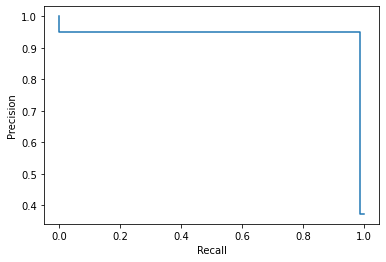

In [150]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


# Testing the SGD model on unseen articles

In [252]:
# Entering the article
article_body ='''


După ravagiile Dianei Șoșoacă prin București sau Cluj, a venit și rândul Mediașului să-și dea prinosul de sânge și chiar zgârciuri pe altarul superbei doamne senator. Aflată în drum spre o degustare-antrenament pentru masa din weekend, Diana Șoșoacă e suspectată de dispariția subită a 7 canibali de vază din Mediaș. Asta în ciuda asigurărilor lui Ghiță Funar că „doamna Diana e blândă, nu mușcă… cel mult te gustă un pic, să vadă dacă ești bine făcut sau mai ai nevoie de coriandru. Altfel n-ar putea să facă rău nici unei barje de sarmale”.

Însă camerele de supraveghere și martorii contrazic dezmințirile. Norocoșii supraviețuitori ai iureșului Șoșoacei prin Mediaș spun că aceasta le-a atacat concetățenii cu sălbăticie, ba chiar cu poftă și nesaț. În doar câteva minute, din fiecare vajnic reprezentant al protipendadei canibale medieșene n-au mai rămas decât hainele și-o mână de metatarsiene uscate. „La masa de protocol, hai, mai înțeleg – doamna senator a confundat șeful de sală cu aperitivele. Aș înțelege și când a crezut că domnul consilier local e inclus în meniu – c-a și comandat idem pentru la cameră. Da’ toți ceilalți?!”, se revoltă un supraviețuitor.

În Mediaș, vecinii și cunoscuții deplâng soarta victimelor. „Era băiat bun, tânăr, zvelt, carnea proaspătă pe el. Și respectuos – mereu dădea «poftă bună» când ne-ntâlneam, îmi pupa mâna, da’ delicat, nu că să pună sare și să mă-ncerce cu incisivii, ca bădăranii. Și doar i-am zis să nu se-apropie de ea, oricâtă poftă i-ar fi făcut, că n-o dovedește și-o să iasă rău… și uite că acuma doamna Diana râgâie liniștită după el, pe când noi tre’ să-i mâncăm nenorocita de colivă vegetariană”, suspină vecina desertului medieșean al Dianei Șoșoacă.

'''
# Lemmatizing the article
lemmatized_article = client.service.parseSentence_XML(article_body)
# Cleaning the article
lemmatized_article = lemmatized_article.split('\n')
lemmas = []
for line in lemmatized_article:
    found = re.search('.*LEMMA="([A-Za-zăâîșț1-9]*)".*', line)
    if found:
        word = found.group(1)
        if word not in stopwords:
            lemmas.append(word)
# Stemming the article
stemmed_words =[]
for word in lemmas:
    stemmed_words.append(stemmer.stem(word))
processed_article = ' '.join(stemmed_words)

In [253]:
### Reinitializing the SGD with Count-Vectorizer model
X_train,X_test,y_train,y_test=train_test_split(df['stemmed_articles'], label, test_size=0.2,shuffle=True)
X_train = tokenizer.texts_to_matrix(X_train,mode='count')
X_test = tokenizer.texts_to_matrix(X_test,mode='count')
model = SGDClassifier()
model.fit(X_train,y_train)

SGDClassifier()

In [256]:
# Transforming the input
# Texts to matrix takes only list or list like objects so I initialized
# a list containing only the user's article
X_input = tokenizer.texts_to_matrix([processed_article],mode='count')
# Testing the model
y_pred = model.predict(X_input)

In [255]:
if y_pred[0] == 0:
    print("Articolul introdus este FAKE.")
else:
    print("Articolul introdus este adevarat.")

Articolul introdus este FAKE.

